In [1]:
import os
import time
import configargparse
import random
import math

import sys
currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)
parentdir = os.path.dirname(parentdir)
print("parent_dir", parentdir)
sys.path.append(parentdir)

import numpy as np

import cv2

import torch
from torch import nn, optim
import dill
from tensorboardX import SummaryWriter
from torchvision.transforms import functional as VF

import opts
import model
import loss
from data import *
from loss import *
from log import *

parent_dir /home/phd/ra153646/robustness/robustdepthflow
Setting up [baseline] perceptual loss: trunk [squeeze], v[0.1], spatial [on]


In [2]:
dataset = "waymo"
dataset_dir = "/data/ra153646/datasets/waymo/waymo76k"
train_file = "/home/phd/ra153646/robustness/robustdepthflow/data/waymo/train_sub0.2.txt"
va_file = "/home/phd/ra153646/robustness/robustdepthflow/data/waymo/val_sub0.2.txt"
test_file = "/home/phd/ra153646/robustness/robustdepthflow/data/waymo/test_sub0.2.txt"
height = 192
width = 480
min_depth = 1
seq_len = 3
load_intrinsics = True
num_scales = 4

train_set = create_dataset(dataset, dataset_dir, train_file, 
    height=height, 
    width=width, 
    num_scales=num_scales, 
    seq_len=seq_len, 
    is_training=False,
    load_intrinsics=load_intrinsics,
    load_depth=True)

In [3]:
batch, _ = train_set[0]
img = util.denormalize(batch[0])[0].numpy()
depth = batch['depth'].numpy()[0]

img = np.transpose(img, (1, 2, 0))

print(img.shape)
print(depth.shape)

(192, 480, 3)
(1280, 1920)


In [4]:
for i in range(10):
    k = np.copy(train_set[i][0]['K'][:3, :3])
    print(k)


[[521.869     0.      235.72691]
 [  0.      313.12143  97.68491]
 [  0.        0.        1.     ]]
[[521.869     0.      235.72691]
 [  0.      313.12143  97.68491]
 [  0.        0.        1.     ]]
[[521.869     0.      235.72691]
 [  0.      313.12143  97.68491]
 [  0.        0.        1.     ]]
[[521.869     0.      235.72691]
 [  0.      313.12143  97.68491]
 [  0.        0.        1.     ]]
[[521.869     0.      235.72691]
 [  0.      313.12143  97.68491]
 [  0.        0.        1.     ]]
[[521.869     0.      235.72691]
 [  0.      313.12143  97.68491]
 [  0.        0.        1.     ]]
[[521.869     0.      235.72691]
 [  0.      313.12143  97.68491]
 [  0.        0.        1.     ]]
[[521.869     0.      235.72691]
 [  0.      313.12143  97.68491]
 [  0.        0.        1.     ]]
[[521.869     0.      235.72691]
 [  0.      313.12143  97.68491]
 [  0.        0.        1.     ]]
[[521.869     0.      235.72691]
 [  0.      313.12143  97.68491]
 [  0.        0.        1.     ]]


In [5]:
x = depth / depth.max()
x[x < 0.1] = 0
x = np.clip(x, 0, 1)

print(x.sum()/np.sum(x > 0.1))
print(x.mean(), x.std(), x.dtype)
print(img.mean(), img.dtype)

0.36401242985262494
0.0028241475 0.036349576 float32
0.5273018 float32


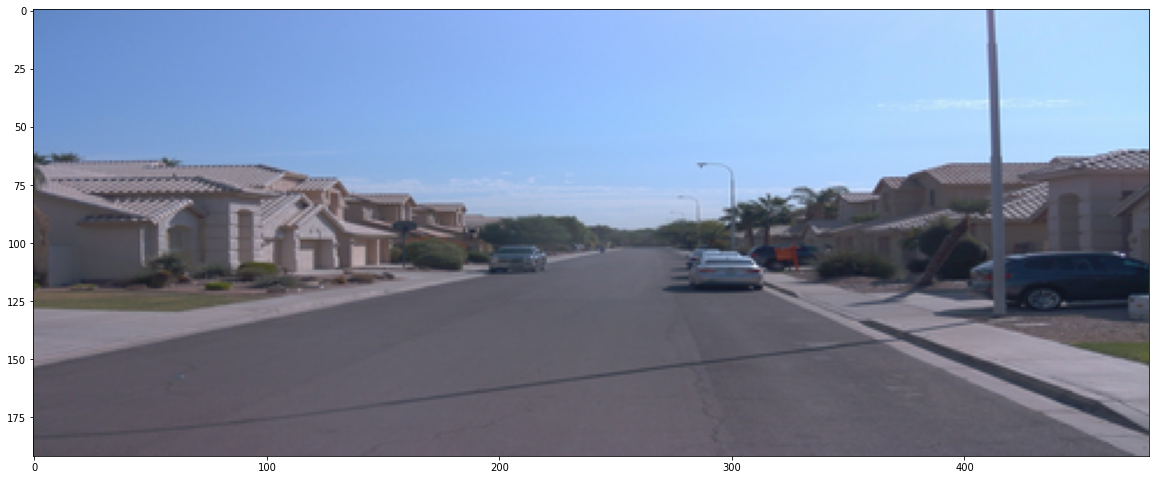

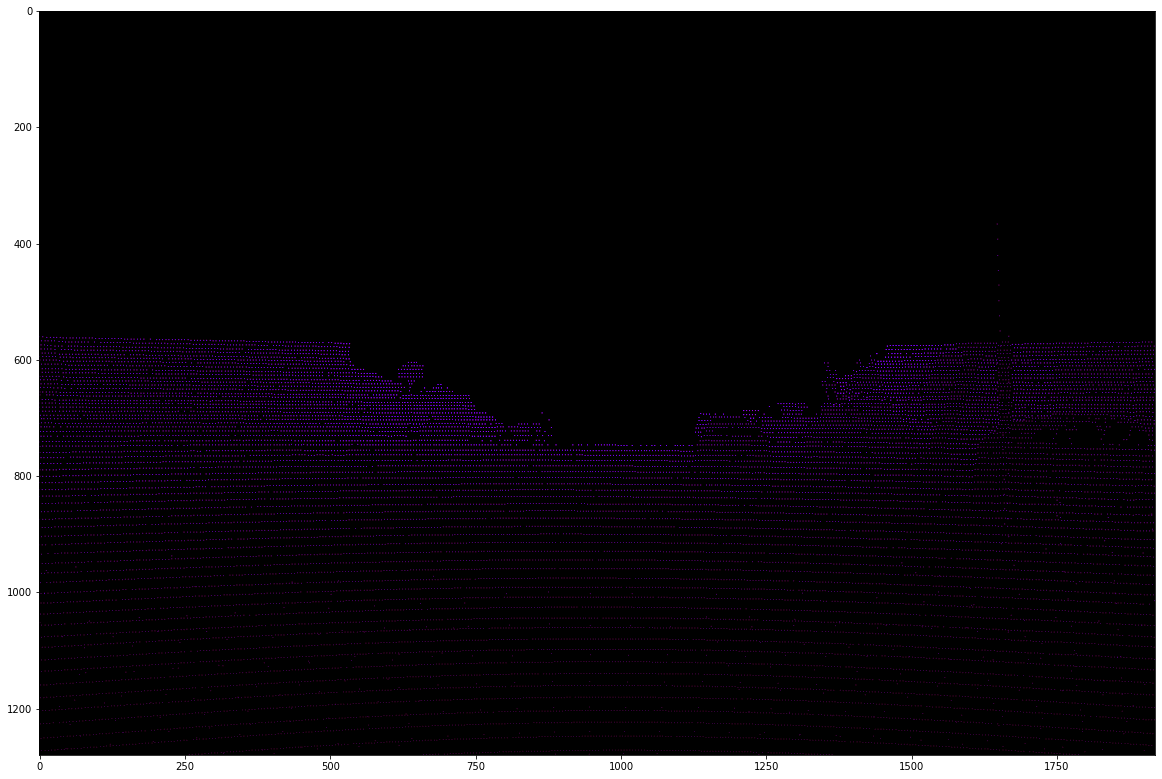

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.show()

plt.figure(figsize=(20, 20))
plt.imshow(x, cmap='gnuplot')

In [7]:
k = np.copy(batch['K'][:3, :3])
dis = np.copy(batch['D'])

# distortion coefficients are the same regardless the spatial resolution (opencv implementation)
# unnedded
def scale_distortion(dis, s):
    dis = np.copy(dis)
    dis[0] *= (1.0/s)**2
    dis[1] *= (1.0/s)**4
    dis[4] *= (1.0/s)**6
    return dis

dis_scaled = scale_distortion(dis, 0.25)

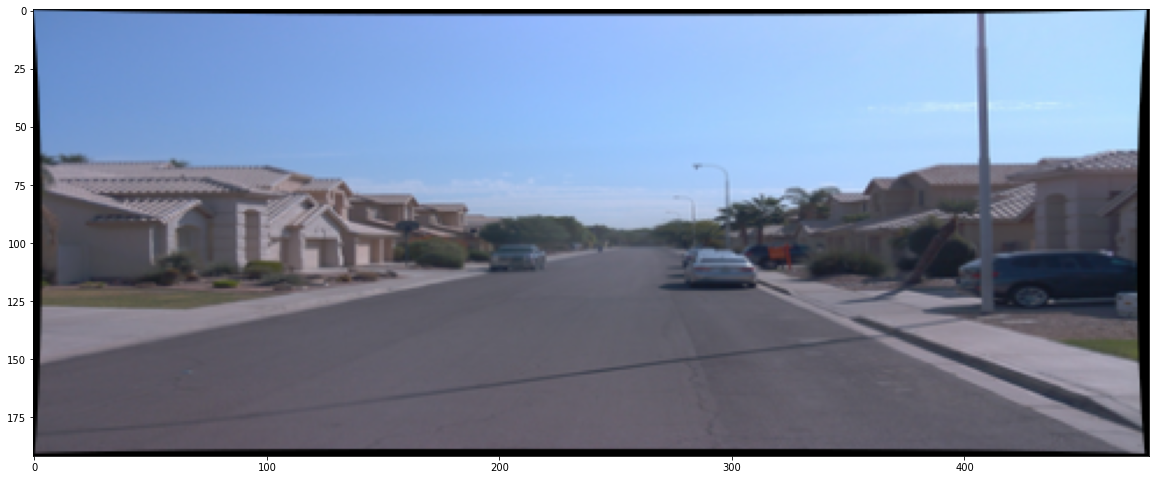

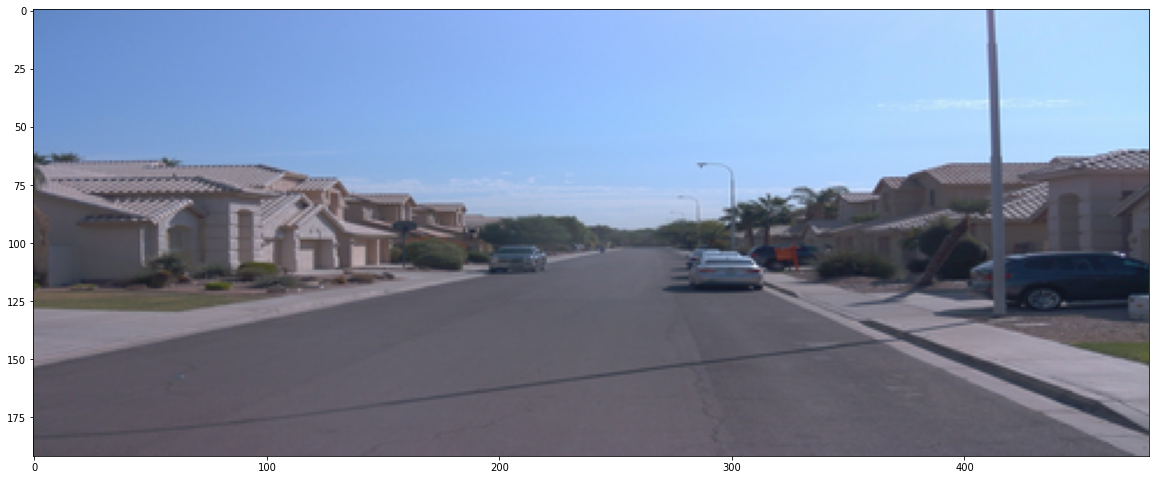

In [8]:
h,  w = img.shape[:2]
new_k, roi = cv2.getOptimalNewCameraMatrix(k, dis, (w,h), 1, (w,h))

# undistort
dst = cv2.undistort(img, k, dis, None, new_k)
plt.figure(figsize=(20, 20))
plt.imshow(dst)

plt.figure(figsize=(20, 20))
plt.imshow(img)


# crop the image
#x, y, w, h = roi
#dst = dst[y:y+h, x:x+w]
#plt.imshow(dst)

## Observations
* Using undistorted images we are supposted to perform reconstruction free of radial and tangential distortion, so, we won't need to modify the model.
    * A problem with this is that it looks like the depth maps is subject to the same distortions as the image.
    * So, we have to undistort the depth maps similarly as we do with the image.
* The other alternative is to embed the distortion/undistortion operators on the model.

In [9]:
diff = np.mean(dst - dst2)
print(diff, np.mean(dst))

print(k, new_k, roi)
dif = np.abs(img - dst)

NameError: name 'dst2' is not defined

# Radial distortion
the equation of ration distortion is 

$$x_{distorted} = x_{undistorted}(1 + k_1 r^2 + k_2 r^4 + k_3 r^6)$$


where $r = r(x, y) = ((x - cx)^2 + (y - cy)^2)^{1/2}$ is distance from $(x, y)$ to the center of the image plane

How to scale the parameters

* If we downscale the image, the coefficients applied to $x_{undistored}$ will be the ones applied to $x_{small}$, where $x_{small} < x_{undistorted}$. So we have to upscale the k to handle the changes.


$$x_{distorted} = x_{undistorted}(1 + k_1 s + k_2 s^2 + k_3 s^3)$$

$s = s(x, y) = (x - cx)^2 + (y - cy)^2$

$sdx = (x - cx)^2$

$sdy = (y - cy)^2$

**Divide the distortion parameters by x, y and scale them individually**. We have to increaste the number of distortion parameters. We can not use opencv because we do not have access to the radius.
$$x_{distorted} = x_{undistorted}(1 + k_1 sdx + k_1 sdy + k_2 sdx^2 + 2 k_2 sdx sdy  + k_2 sdy^2 + k_3 sdx^3 + 3 k_3 sdx^2 sdy + 3 k_3 sdx sdy^2 + k_3 sdy ^ 3)$$

**Implemented the undistortion algorithm and scale the radious**.

**Use the same scale factor on x, y and scale the intrinsics accordingly.**

***We do not need to do anything, distortion does not change with resolution***

